In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import polars as pl
import scipy.stats as stats
import scipy.sparse as sps
import gc
import tqdm

from ebrec.utils._descriptive_analysis import (
    min_max_impression_time_behaviors, 
    min_max_impression_time_history
)
from ebrec.utils._polars import slice_join_dataframes
from ebrec.utils._behaviors import (
    create_binary_labels_column,
    sampling_strategy_wu2019,
    truncate_history,
)
from ebrec.utils._constants import (
    DEFAULT_HISTORY_ARTICLE_ID_COL,
    DEFAULT_CLICKED_ARTICLES_COL,
    DEFAULT_INVIEW_ARTICLES_COL,
    DEFAULT_USER_COL
)
from ebrec.evaluation.metrics_protocols import *
from polimi.utils._catboost import add_trendiness_feature, add_mean_delays_features,add_history_trendiness_scores_feature

from catboost import CatBoostClassifier

2024-05-12 21:46:42.150842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 21:46:43.087328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Memory Utils

In [2]:
from os import system, getpid, walk
from psutil import Process
from colorama import Fore, Style, init
from IPython.display import display, HTML

def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    print(style + color + text + Style.RESET_ALL)
    
def GetMemUsage():   
    pid = getpid()
    py = Process(pid)
    memory_use = py.memory_info()[0] / 2. ** 30
    return f"RAM memory GB usage = {memory_use :.4}"

PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.9003


In [3]:
def reduce_polars_df_memory_size(df, set_categorical=True):

    start_mem = df.estimated_size('mb')
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in [pl.Int16, pl.Int32, pl.Int64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(pl.col(col).cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(pl.col(col).cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
        elif col_type in [pl.UInt16, pl.UInt32, pl.UInt64]:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt8))
            elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt16))
            elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                df = df.with_columns(pl.col(col).cast(pl.UInt32))
        elif col_type == pl.Float64:
            c_min = df[col].fill_null(0).min()
            c_max = df[col].fill_null(0).max()
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(pl.col(col).cast(pl.Float32))

    gc.collect()
    end_mem = df.estimated_size('mb')
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Data import

In [4]:
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_demo/articles.parquet')

behaviors_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_demo/train/behaviors.parquet')
history_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_demo/train/history.parquet')

behaviors_val = pl.read_parquet('/home/ubuntu/dataset/ebnerd_demo/validation/behaviors.parquet')
history_val = pl.read_parquet('/home/ubuntu/dataset/ebnerd_demo/validation/history.parquet')

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 0.9934


In [5]:
behaviors_train.head()

impression_id,article_id,impression_time,read_time,scroll_percentage,device_type,article_ids_inview,article_ids_clicked,user_id,is_sso_user,gender,postcode,age,is_subscriber,session_id,next_read_time,next_scroll_percentage
u32,i32,datetime[μs],f32,f32,i8,list[i32],list[i32],u32,bool,i8,i8,i8,bool,u32,f32,f32
48401,null,2023-05-21 21:06:50,21.0,null,2,"[9774516, 9771051, … 9759966]",[9759966],22779,false,null,null,null,false,21,16.0,27.0
152513,9778745,2023-05-24 07:31:26,30.0,100.0,1,"[9778669, 9778736, … 9777397]",[9778661],150224,false,null,null,null,false,298,2.0,48.0
155390,null,2023-05-24 07:30:33,45.0,null,1,"[9778369, 9777856, … 9778448]",[9777856],160892,false,null,null,null,false,401,215.0,100.0
214679,null,2023-05-23 05:25:40,33.0,null,2,"[9776715, 9776406, … 9776855]",[9776566],1001055,false,null,null,null,false,1357,40.0,47.0
214681,null,2023-05-23 05:31:54,21.0,null,2,"[9775202, 9776855, … 9776570]",[9776553],1001055,false,null,null,null,false,1358,5.0,49.0


# Articles Preprocessing

In [6]:
from polimi.preprocessing_pipelines.pre_127 import build_features as build_features_127f
is_test_data = False
sample = True
dataset_type = 'train'
dataset, tf_idf_vectorizer, unique_entities = build_features_127f(behaviors = behaviors_train, history =history_train,
                                                                  articles= articles, test=is_test_data, sample=sample, previous_version=None,
                                                                  urm_path=None, ners_models_path=None, split_type=dataset_type,
                                                                  output_path=None, recsys_models_path=None,recsys_urm_path=None)

2it [00:01,  1.84it/s]                       


Memory usage of dataframe is 4.27 MB
Memory usage after optimization is: 4.19 MB
Decreased by 1.9%


2it [00:02,  1.05s/it]                       
259it [00:00, 741.51it/s]                         
2it [00:00, 13.50it/s]                       
2it [00:00, 12.80it/s]                       
100%|██████████| 506/506 [00:00<00:00, 926.14it/s] 


Memory usage of dataframe is 8.31 MB
Memory usage after optimization is: 5.41 MB
Decreased by 34.9%
Memory usage of dataframe is 5.98 MB
Memory usage after optimization is: 5.69 MB
Decreased by 4.9%


4it [00:39,  9.81s/it]                       


Memory usage of dataframe is 29.07 MB
Memory usage after optimization is: 20.36 MB
Decreased by 30.0%


4it [00:00,  4.62it/s]                       


Memory usage of dataframe is 28.31 MB
Memory usage after optimization is: 23.35 MB
Decreased by 17.5%


8it [00:38,  4.85s/it]                       


Memory usage of dataframe is 29.87 MB
Memory usage after optimization is: 27.89 MB
Decreased by 6.6%


In [7]:
def normalize_endorsement(articles_endorsement_raw, col_name='endorsement_10h', over_article_topics = 'article'):
    return articles_endorsement_raw.sort(by='impression_time').with_columns(
        (
            pl.col(col_name) / 
            pl.col(col_name).sum().over('impression_time')
        ).alias(f'normalized_{col_name}'),
        (
            pl.col(col_name) - 
            pl.col(col_name).rolling_mean(10, min_periods=1).over(over_article_topics)
        ).alias(f'{col_name}_diff_rolling'),
        (
            pl.col(col_name).rolling_mean(5, min_periods=1).over(over_article_topics) - 
            pl.col(col_name).rolling_mean(10, min_periods=1).over(over_article_topics)
        ).alias(f'{col_name}_macd'),
        (
            pl.col(col_name) / 
            pl.col(col_name).quantile(0.8).over('impression_time')
        ).alias(f'{col_name}quantile_norm')
    ).with_columns(
        (
            pl.col(f'normalized_{col_name}') / 
            pl.col(f'normalized_{col_name}').rolling_max(10, min_periods=1).over('impression_time')
        ).alias(f'normalized_{col_name}_rolling_max_ratio'),
    )

In [8]:

period ='10h'
end_2 = dataset.select('article', 'impression_time')\
        .join(articles.select(['article_id','topics']), left_on = 'article', right_on = 'article_id')\
        .explode('topics')\
     .with_columns(pl.col('impression_time').dt.round('1m').alias('impression_time_rounded'))\
     .group_by(['impression_time_rounded','topics']).len()\
        .rename({'impression_time_rounded': 'impression_time', 'len':f'topic_endorsement_{period}'}) \
        .sort("impression_time").set_sorted("impression_time") \
        .rolling(index_column="impression_time", period=period, group_by='topics').agg(
            pl.col(f'topic_endorsement_{period}').sum()
        ).unique(["topics","impression_time"])
        
#end_2 = normalize_endorsement(end_2, f'topic_endorsement_{period}', over_article_topics='topics')

#NORMALIZE_OVER_IMPRESSION_ID = [f'topic_endorsement_{period}']

# end_2 = dataset.select('article', 'impression_time','impression_id')\
#         .join(articles.select(['article_id','topics']), left_on = 'article', right_on = 'article_id')\
#         .explode('topics')\
#         .join_asof(end_2, by='topics', on='impression_time')
        
# end_2 = end_2.with_columns(
#     *[(pl.col(c) / pl.col(c).max().over(pl.col('impression_id'))).alias(f'{c}_l_inf_impression')
#       for c in NORMALIZE_OVER_IMPRESSION_ID],
#     *[(pl.col(c) / pl.col(c).rank(method='min').over(pl.col('impression_id'))).alias(f'{c}_rank_impression')
#       for c in NORMALIZE_OVER_IMPRESSION_ID],
#     *[pl.col(c).std().over(pl.col('impression_id')).alias(f'std_impression_{c}')
#       for c in NORMALIZE_OVER_IMPRESSION_ID],
#     *[pl.col(c).skew().over(pl.col('impression_id')).alias(f'skew_impression_{c}')
#       for c in NORMALIZE_OVER_IMPRESSION_ID],
#     *[pl.col(c).kurtosis().over(pl.col('impression_id')).alias(f'kurtosis_impression_{c}')
#       for c in NORMALIZE_OVER_IMPRESSION_ID])

aggregate_col = end_2.columns
drop_cols = ['article', 'impression_time', 'impression_id','topics']
aggregate_col = [c for c in aggregate_col if c not in drop_cols]

to_join = dataset.select('article', 'impression_time')\
        .join(articles.select(['article_id','topics']), left_on = 'article', right_on = 'article_id')\
        .explode('topics')\
        .join_asof(end_2, by='topics', on='impression_time')\
        .group_by(['impression_time','article'])\
        .agg(
              *[pl.col(column).mean().alias(f'mean_{column}') for column in aggregate_col],
              *[pl.col(column).max().alias(f'max_{column}') for column in aggregate_col],
              *[pl.col(column).min().alias(f'min_{column}') for column in aggregate_col],
        )

dataset = dataset.join(to_join, on = ['article','impression_time'])

In [9]:
normalize_columns = ['total_pageviews', 'total_inviews', 'total_read_time','click_ratio']
dataset = dataset.join(articles.select(['article_id','total_pageviews','total_inviews', 'total_read_time']).fill_null(0), left_on = 'article', right_on = 'article_id')\
    .with_columns(
        (pl.col('total_pageviews')/pl.col('total_inviews')).alias('click_ratio')
    )\
    .with_columns(
        *[(pl.col(col) / pl.col(col).max().over('article')).alias(f'art_norm_{col}') for col in normalize_columns],
        *[(pl.col(col) / pl.col(col).max().over('user_id')).alias(f'usr_norm_{col}') for col in normalize_columns] 
    )

In [10]:
emb = pl.read_parquet("/home/ubuntu/dataset/emotions_embedding.parquet").with_columns(pl.col("emotion_scores").list.to_struct()).unnest("emotion_scores")

dataset = dataset.join(emb, left_on = 'article', right_on='article_id', how='left').rename({'field_0': 'emotion_0', 'field_1': 'emotion_1', 'field_2' : 'emotion_2', 'field_3': 'emotion_3',
             'field_4': 'emotion_4', 'field_5':'emoiton_5'})
embedding_len = 6
dataset = dataset.join(history_train.select(['user_id','article_id_fixed']).explode('article_id_fixed').join(emb, left_on = 'article_id_fixed', right_on='article_id', how='left')\
.group_by('user_id').agg(
            [pl.col(f'field_{i}').mean().cast(pl.Float32).alias(f'user_emotion{i}') for i in range(embedding_len)]), on='user_id')

In [11]:
emb = pl.read_parquet('/mnt/ebs_volume_2/click_predictors/train_click_predictor.parquet')
emb_col = emb.limit(1).drop(['user_id','article']).columns
dataset = dataset.join(emb, on=['user_id','article'], how='left')

dataset = dataset.with_columns(
    *[(pl.col(col) / pl.col(col).max().over('impression_id')).alias(f'imp_norm_{col}') for col in emb_col],
)


In [12]:
dataset.head()

impression_id,article,user_id,impression_time,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,target,trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,article_delay_days,article_delay_hours,Entity_MISC_Present,Entity_PROD_Present,Entity_EVENT_Present,Entity_ORG_Present,Entity_PER_Present,Entity_LOC_Present,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,…,TW_click_predictor_kenneth,SP%W_click_predictor_kenneth,readtime_click_predictor_kenneth,TW_click_predictor_w2v,SP%W_click_predictor_w2v,readtime_click_predictor_w2v,TW_click_predictor_emotion,SP%W_click_predictor_emotion,readtime_click_predictor_emotion,imp_norm_emotions_user_item_distance,imp_norm_word2vec_user_item_distance,imp_norm_contrastive_user_item_distance,imp_norm_roberta_user_item_distance,imp_norm_distil_user_item_distance,imp_norm_bert_user_item_distance,imp_norm_kenneth_user_item_distance,imp_norm_TW_click_predictor_distilbert,imp_norm_SP%W_click_predictor_distilbert,imp_norm_readtime_click_predictor_distilbert,imp_norm_TW_click_predictor_bert,imp_norm_SP%W_click_predictor_bert,imp_norm_readtime_click_predictor_bert,imp_norm_TW_click_predictor_roberta,imp_norm_SP%W_click_predictor_roberta,imp_norm_readtime_click_predictor_roberta,imp_norm_TW_click_predictor_contrastive,imp_norm_SP%W_click_predictor_contrastive,imp_norm_readtime_click_predictor_contrastive,imp_norm_TW_click_predictor_kenneth,imp_norm_SP%W_click_predictor_kenneth,imp_norm_readtime_click_predictor_kenneth,imp_norm_TW_click_predictor_w2v,imp_norm_SP%W_click_predictor_w2v,imp_norm_readtime_click_predictor_w2v,imp_norm_TW_click_predictor_emotion,imp_norm_SP%W_click_predictor_emotion,imp_norm_readtime_click_predictor_emotion
u32,i32,u32,datetime[μs],i8,f32,f32,bool,i8,i8,bool,i8,i16,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,u32,i16,i32,bool,bool,bool,bool,bool,bool,i8,f32,i16,bool,bool,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
126248138,9771787,1974260,2023-05-19 05:11:10,1,12.0,null,false,2,null,false,0,279,5,5,false,142,0.9921,"""Negative""",1,7,27,194,3,0,0,false,false,true,true,true,true,0,0.5,-72,true,false,…,0.84967,0.802626,0.800318,0.159398,0.132731,0.13069,0.471979,0.30425,0.304603,0.860321,1.0,1.0,1.0,0.374196,1.0,1.0,0.294665,0.399803,0.39197,1.0,1.0,1.0,0.980778,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.99174,0.88293,0.85482
228147007,9778623,2150451,2023-05-24 06:38:47,2,120.0,100.0,false,2,null,false,0,256,3,6,false,142,0.9893,"""Negative""",2,7,18,445,3,0,0,false,false,false,true,true,true,0,0.5,10,false,false,…,0.692941,0.539545,0.53344,0.126132,0.104156,0.102313,0.558611,0.448257,0.432226,1.0,1.0,1.0,0.975482,0.914197,0.735172,1.0,0.78082,0.93087,0.915119,0.919259,0.736975,0.734552,0.871111,0.986701,0.976421,0.889007,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
577551970,9772082,554785,2023-05-19 07:25:29,2,20.0,null,false,2,null,false,0,267,5,7,false,414,0.8208,"""Negative""",2,6,27,205,5,0,1,false,true,false,true,true,false,3,2.0,-48,true,false,…,0.73194,0.608857,0.619339,0.20788,0.136585,0.13716,0.272718,0.092104,0.084542,0.72457,1.0,0.765177,0.737857,0.801442,1.0,0.810057,0.74716,0.845852,0.810545,1.0,1.0,1.0,1.0,0.732008,0.751353,1.0,0.733995,0.76426,0.931979,0.780853,0.810113,1.0,1.0,1.0,0.910668,0.767058,0.695731
405530215,9746360,204031,2023-05-19 11:50:04,2,33.0,100.0,false,2,null,false,0,88,5,11,false,414,0.5136,"""Positive""",10,13,31,1258,2,16,405,false,true,true,false,true,true,0,4.0,30,true,false,…,0.614754,0.713886,0.709954,0.071619,0.099138,0.095799,0.164313,0.236174,0.222284,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.911219,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.946274,1.0,1.0,0.926964,1.0,1.0,0.79299,1.0,1.0,1.0,1.0,1.0
322085658,9774125,291051,2023-05-20 23:10:39,2,23.0,100.0,false,2,null,false,0,94,6,

In [13]:
print(dataset.shape)
dataset.head()

(74277, 211)


impression_id,article,user_id,impression_time,device_type,read_time,scroll_percentage,is_sso_user,gender,age,is_subscriber,target,trendiness_score,weekday,hour,premium,category,sentiment_score,sentiment_label,num_images,title_len,subtitle_len,body_len,num_topics,article_delay_days,article_delay_hours,Entity_MISC_Present,Entity_PROD_Present,Entity_EVENT_Present,Entity_ORG_Present,Entity_PER_Present,Entity_LOC_Present,last_session_duration,mean_prev_sessions_duration,last_session_time_hour_diff,is_new_article,is_already_seen_article,…,TW_click_predictor_kenneth,SP%W_click_predictor_kenneth,readtime_click_predictor_kenneth,TW_click_predictor_w2v,SP%W_click_predictor_w2v,readtime_click_predictor_w2v,TW_click_predictor_emotion,SP%W_click_predictor_emotion,readtime_click_predictor_emotion,imp_norm_emotions_user_item_distance,imp_norm_word2vec_user_item_distance,imp_norm_contrastive_user_item_distance,imp_norm_roberta_user_item_distance,imp_norm_distil_user_item_distance,imp_norm_bert_user_item_distance,imp_norm_kenneth_user_item_distance,imp_norm_TW_click_predictor_distilbert,imp_norm_SP%W_click_predictor_distilbert,imp_norm_readtime_click_predictor_distilbert,imp_norm_TW_click_predictor_bert,imp_norm_SP%W_click_predictor_bert,imp_norm_readtime_click_predictor_bert,imp_norm_TW_click_predictor_roberta,imp_norm_SP%W_click_predictor_roberta,imp_norm_readtime_click_predictor_roberta,imp_norm_TW_click_predictor_contrastive,imp_norm_SP%W_click_predictor_contrastive,imp_norm_readtime_click_predictor_contrastive,imp_norm_TW_click_predictor_kenneth,imp_norm_SP%W_click_predictor_kenneth,imp_norm_readtime_click_predictor_kenneth,imp_norm_TW_click_predictor_w2v,imp_norm_SP%W_click_predictor_w2v,imp_norm_readtime_click_predictor_w2v,imp_norm_TW_click_predictor_emotion,imp_norm_SP%W_click_predictor_emotion,imp_norm_readtime_click_predictor_emotion
u32,i32,u32,datetime[μs],i8,f32,f32,bool,i8,i8,bool,i8,i16,i8,i8,bool,i16,f32,str,u32,u8,u8,u16,u32,i16,i32,bool,bool,bool,bool,bool,bool,i8,f32,i16,bool,bool,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
126248138,9771787,1974260,2023-05-19 05:11:10,1,12.0,null,false,2,null,false,0,279,5,5,false,142,0.9921,"""Negative""",1,7,27,194,3,0,0,false,false,true,true,true,true,0,0.5,-72,true,false,…,0.84967,0.802626,0.800318,0.159398,0.132731,0.13069,0.471979,0.30425,0.304603,0.860321,1.0,1.0,1.0,0.374196,1.0,1.0,0.294665,0.399803,0.39197,1.0,1.0,1.0,0.980778,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.99174,0.88293,0.85482
228147007,9778623,2150451,2023-05-24 06:38:47,2,120.0,100.0,false,2,null,false,0,256,3,6,false,142,0.9893,"""Negative""",2,7,18,445,3,0,0,false,false,false,true,true,true,0,0.5,10,false,false,…,0.692941,0.539545,0.53344,0.126132,0.104156,0.102313,0.558611,0.448257,0.432226,1.0,1.0,1.0,0.975482,0.914197,0.735172,1.0,0.78082,0.93087,0.915119,0.919259,0.736975,0.734552,0.871111,0.986701,0.976421,0.889007,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
577551970,9772082,554785,2023-05-19 07:25:29,2,20.0,null,false,2,null,false,0,267,5,7,false,414,0.8208,"""Negative""",2,6,27,205,5,0,1,false,true,false,true,true,false,3,2.0,-48,true,false,…,0.73194,0.608857,0.619339,0.20788,0.136585,0.13716,0.272718,0.092104,0.084542,0.72457,1.0,0.765177,0.737857,0.801442,1.0,0.810057,0.74716,0.845852,0.810545,1.0,1.0,1.0,1.0,0.732008,0.751353,1.0,0.733995,0.76426,0.931979,0.780853,0.810113,1.0,1.0,1.0,0.910668,0.767058,0.695731
405530215,9746360,204031,2023-05-19 11:50:04,2,33.0,100.0,false,2,null,false,0,88,5,11,false,414,0.5136,"""Positive""",10,13,31,1258,2,16,405,false,true,true,false,true,true,0,4.0,30,true,false,…,0.614754,0.713886,0.709954,0.071619,0.099138,0.095799,0.164313,0.236174,0.222284,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.911219,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.946274,1.0,1.0,0.926964,1.0,1.0,0.79299,1.0,1.0,1.0,1.0,1.0
322085658,9774125,291051,2023-05-20 23:10:39,2,23.0,100.0,false,2,null,false,0,94,6,

In [14]:
train_ds = dataset.drop(['impression_id', 'article', 'user_id']).to_pandas()

if 'impression_time' in train_ds.columns:
    train_ds = train_ds.drop(columns =  ['impression_time'])
    

categorical_columns = ['device_type', 'is_sso_user', 'gender', 'is_subscriber', 'weekday',
                       'premium', 'category', 'sentiment_label', 'is_new_article', 'is_already_seen_article',
                       'MostFrequentCategory', 'MostFrequentWeekday', 'IsFavouriteCategory']
categorical_columns += [f'Entity_{entity}_Present' for entity in unique_entities]
train_ds[categorical_columns] = train_ds[categorical_columns].astype('category')

X = train_ds.drop(columns=['target'])
y = train_ds['target']

In [15]:
del train_ds

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 13.47


In [16]:
args = {
    "iterations": 4585, 
    "learning_rate": 0.00512546606087225,
    "rsm": 0.6672940287881072, 
    "reg_lambda": 0.0592615310786739, 
    "grow_policy": "Depthwise", 
    "bootstrap_type": "MVS", 
    "subsample": 0.2444604534092856, 
    "random_strength": 0.01866366217019646, 
    "fold_permutation_block": 79, 
    "border_count": 33, 
    "sampling_frequency": "PerTreeLevel",
    "score_function": "Cosine", 
    "depth": 10, 
    "min_data_in_leaf": 242.40758300164973, 
    "mvs_reg": 0.012961207712188887
}

In [17]:
# just a simple model to be able to run an evaluation
model = CatBoostClassifier(cat_features=categorical_columns, **args)

model.fit(X, y, verbose=25)

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)

0:	learn: 0.6914285	total: 106ms	remaining: 8m 6s
25:	learn: 0.6546634	total: 1.38s	remaining: 4m 2s
50:	learn: 0.6277515	total: 2.63s	remaining: 3m 53s
75:	learn: 0.6077186	total: 3.9s	remaining: 3m 51s
100:	learn: 0.5926144	total: 5.16s	remaining: 3m 49s
125:	learn: 0.5808627	total: 6.42s	remaining: 3m 47s
150:	learn: 0.5716520	total: 7.66s	remaining: 3m 44s
175:	learn: 0.5641051	total: 8.89s	remaining: 3m 42s
200:	learn: 0.5580475	total: 10.1s	remaining: 3m 41s
225:	learn: 0.5527689	total: 11.4s	remaining: 3m 39s
250:	learn: 0.5482556	total: 12.6s	remaining: 3m 37s
275:	learn: 0.5445066	total: 13.8s	remaining: 3m 35s
300:	learn: 0.5411259	total: 15s	remaining: 3m 33s
325:	learn: 0.5381407	total: 16.2s	remaining: 3m 32s
350:	learn: 0.5353771	total: 17.4s	remaining: 3m 30s
375:	learn: 0.5328701	total: 18.6s	remaining: 3m 28s
400:	learn: 0.5306325	total: 19.8s	remaining: 3m 26s
425:	learn: 0.5285195	total: 21s	remaining: 3m 24s
450:	learn: 0.5265444	total: 22.2s	remaining: 3m 23s
475:	

In [18]:
%%time

from catboost import Pool

train_pool = Pool(X, y, cat_features=categorical_columns)
feature_importances = model.get_feature_importance(train_pool)

CPU times: user 15.1 s, sys: 39.8 ms, total: 15.1 s
Wall time: 15.1 s


Text(0.5, 1.0, 'Catboost Feature Importances')

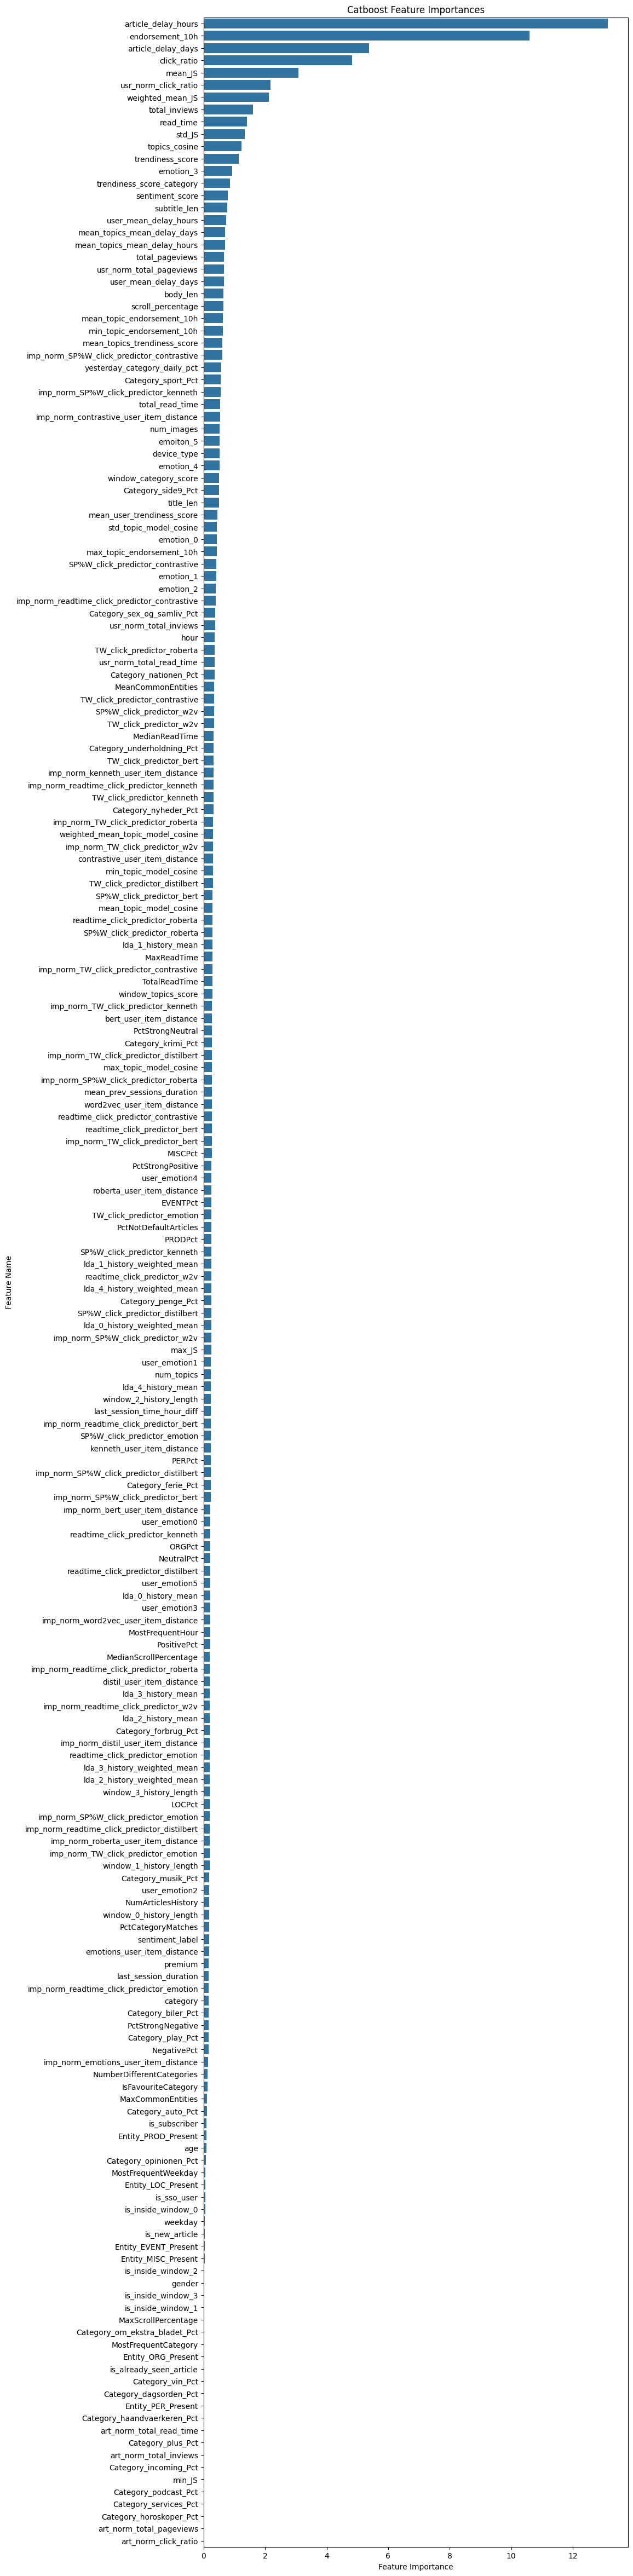

In [19]:
sorted_importances = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 60))
sns.barplot(x=feature_importances[sorted_importances], y=np.array(X.columns)[sorted_importances])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Catboost Feature Importances')

In [20]:
del history_train
del behaviors_train

gc.collect()
PrintColor(f"\n" + GetMemUsage(), color = Fore.RED)


RAM memory GB usage = 13.83


In [21]:
# model.get_param('cat_features')

# Model Evaluation

In [22]:
is_test_data = False
sample = False
dataset_type = 'validation'
dataset, tf_idf_vectorizer, unique_entities = build_features_127f(behaviors = behaviors_val, history =history_val,
                                                                  articles= articles, test=is_test_data, sample=sample, previous_version=None,
                                                                  urm_path=None, ners_models_path=None, split_type=dataset_type,
                                                                  output_path=None, recsys_models_path=None,recsys_urm_path=None)

2it [00:01,  1.93it/s]                       


Memory usage of dataframe is 4.02 MB
Memory usage after optimization is: 3.94 MB
Decreased by 2.0%


2it [00:01,  1.05it/s]                       
241it [00:00, 738.97it/s]                         
2it [00:00, 15.14it/s]                       
2it [00:00, 13.01it/s]                       
100%|██████████| 507/507 [00:00<00:00, 773.19it/s]


Memory usage of dataframe is 34.11 MB
Memory usage after optimization is: 22.18 MB
Decreased by 35.0%
Memory usage of dataframe is 24.55 MB
Memory usage after optimization is: 23.35 MB
Decreased by 4.9%


16it [02:23,  8.95s/it]                        


Memory usage of dataframe is 119.34 MB
Memory usage after optimization is: 83.58 MB
Decreased by 30.0%


16it [00:03,  4.52it/s]                        


Memory usage of dataframe is 116.22 MB
Memory usage after optimization is: 96.15 MB
Decreased by 17.3%


31it [02:21,  4.57s/it]                        


Memory usage of dataframe is 122.91 MB
Memory usage after optimization is: 114.76 MB
Decreased by 6.6%


In [23]:

period ='10h'
end_2 = dataset.select('article', 'impression_time')\
        .join(articles.select(['article_id','topics']), left_on = 'article', right_on = 'article_id')\
        .explode('topics')\
     .with_columns(pl.col('impression_time').dt.round('1m').alias('impression_time_rounded'))\
     .group_by(['impression_time_rounded','topics']).len()\
        .rename({'impression_time_rounded': 'impression_time', 'len':f'topic_endorsement_{period}'}) \
        .sort("impression_time").set_sorted("impression_time") \
        .rolling(index_column="impression_time", period=period, group_by='topics').agg(
            pl.col(f'topic_endorsement_{period}').sum()
        ).unique(["topics","impression_time"])
        
# end_2 = normalize_endorsement(end_2, f'topic_endorsement_{period}', over_article_topics='topics')

# NORMALIZE_OVER_IMPRESSION_ID = [f'topic_endorsement_{period}']

# end_2 = dataset.select('article', 'impression_time','impression_id')\
#         .join(articles.select(['article_id','topics']), left_on = 'article', right_on = 'article_id')\
#         .explode('topics')\
#         .join_asof(end_2, by='topics', on='impression_time')
        
# end_2 = end_2.with_columns(
#     *[(pl.col(c) / pl.col(c).max().over(pl.col('impression_id'))).alias(f'{c}_l_inf_impression')
#       for c in NORMALIZE_OVER_IMPRESSION_ID],
#     *[(pl.col(c) / pl.col(c).rank(method='min').over(pl.col('impression_id'))).alias(f'{c}_rank_impression')
#       for c in NORMALIZE_OVER_IMPRESSION_ID],
#     *[pl.col(c).std().over(pl.col('impression_id')).alias(f'std_impression_{c}')
#       for c in NORMALIZE_OVER_IMPRESSION_ID],
#     *[pl.col(c).skew().over(pl.col('impression_id')).alias(f'skew_impression_{c}')
#       for c in NORMALIZE_OVER_IMPRESSION_ID],
#     *[pl.col(c).kurtosis().over(pl.col('impression_id')).alias(f'kurtosis_impression_{c}')
#       for c in NORMALIZE_OVER_IMPRESSION_ID])

aggregate_col = end_2.columns
# print(end_2.columns)
drop_cols = ['article', 'impression_time', 'impression_id','topics']
aggregate_col = [c for c in aggregate_col if c not in drop_cols]

to_join = dataset.select('article', 'impression_time')\
        .join(articles.select(['article_id','topics']), left_on = 'article', right_on = 'article_id')\
        .explode('topics')\
        .join_asof(end_2, by='topics', on='impression_time')\
        .group_by(['impression_time','article'])\
        .agg(
              *[pl.col(column).mean().alias(f'mean_{column}') for column in aggregate_col],
              *[pl.col(column).max().alias(f'max_{column}') for column in aggregate_col],
              *[pl.col(column).min().alias(f'min_{column}') for column in aggregate_col],
        )

print(to_join.head())
dataset = dataset.join(to_join, on = ['article','impression_time'])

shape: (5, 5)
┌─────────────────────┬─────────┬──────────────────────┬─────────────────────┬─────────────────────┐
│ impression_time     ┆ article ┆ mean_topic_endorseme ┆ max_topic_endorseme ┆ min_topic_endorseme │
│ ---                 ┆ ---     ┆ nt_10h               ┆ nt_10h              ┆ nt_10h              │
│ datetime[μs]        ┆ i32     ┆ ---                  ┆ ---                 ┆ ---                 │
│                     ┆         ┆ f64                  ┆ u32                 ┆ u32                 │
╞═════════════════════╪═════════╪══════════════════════╪═════════════════════╪═════════════════════╡
│ 2023-05-30 12:09:45 ┆ 9527795 ┆ 2157.0               ┆ 2157                ┆ 2157                │
│ 2023-05-31 13:23:53 ┆ 9789728 ┆ 3150.333333          ┆ 4316                ┆ 1731                │
│ 2023-05-27 17:44:57 ┆ 9465878 ┆ 1971.4               ┆ 4029                ┆ 68                  │
│ 2023-05-29 10:55:23 ┆ 9785751 ┆ 2369.333333          ┆ 5921                

In [24]:
normalize_columns = ['total_pageviews', 'total_inviews', 'total_read_time','click_ratio']
dataset = dataset.join(articles.select(['article_id','total_pageviews','total_inviews', 'total_read_time']).fill_null(0), left_on = 'article', right_on = 'article_id')\
    .with_columns(
        (pl.col('total_pageviews')/pl.col('total_inviews')).alias('click_ratio')
    )\
    .with_columns(
        *[(pl.col(col) / pl.col(col).max().over('article')).alias(f'art_norm_{col}') for col in normalize_columns],
        *[(pl.col(col) / pl.col(col).max().over('user_id')).alias(f'usr_norm_{col}') for col in normalize_columns] 
    )

In [25]:
emb = pl.read_parquet("/home/ubuntu/dataset/emotions_embedding.parquet").with_columns(pl.col("emotion_scores").list.to_struct()).unnest("emotion_scores")

dataset = dataset.join(emb, left_on = 'article', right_on='article_id', how='left').rename({'field_0': 'emotion_0', 'field_1': 'emotion_1', 'field_2' : 'emotion_2', 'field_3': 'emotion_3',
             'field_4': 'emotion_4', 'field_5':'emoiton_5'})
embedding_len = 6
dataset = dataset.join(history_val.select(['user_id','article_id_fixed']).explode('article_id_fixed').join(emb, left_on = 'article_id_fixed', right_on='article_id', how='left')\
.group_by('user_id').agg(
            [pl.col(f'field_{i}').mean().cast(pl.Float32).alias(f'user_emotion{i}') for i in range(embedding_len)]), on='user_id')

In [26]:
emb = pl.read_parquet('/mnt/ebs_volume_2/click_predictors/validation_click_predictor.parquet')
emb_col = emb.drop(['user_id','article']).columns
dataset = dataset.join(emb, on=['user_id','article'], how='left')

dataset = dataset.with_columns(
    *[(pl.col(col) / pl.col(col).max().over('impression_id')).alias(f'imp_norm_{col}') for col in emb_col],
    *[(pl.col(col) / pl.col(col).max().over('article')).alias(f'art_norm_{col}') for col in emb_col],
    *[(pl.col(col) / pl.col(col).max().over('user_id')).alias(f'usr_norm_{col}') for col in emb_col] 
)

In [27]:
del history_val
del articles
del behaviors_val

gc.collect()

0

In [28]:
model.get_param('cat_features')

['device_type',
 'is_sso_user',
 'gender',
 'is_subscriber',
 'weekday',
 'premium',
 'category',
 'sentiment_label',
 'is_new_article',
 'is_already_seen_article',
 'MostFrequentCategory',
 'MostFrequentWeekday',
 'IsFavouriteCategory',
 'Entity_MISC_Present',
 'Entity_PROD_Present',
 'Entity_EVENT_Present',
 'Entity_ORG_Present',
 'Entity_PER_Present',
 'Entity_LOC_Present']

In [29]:
# impression_id will be later useful for evaluation
val_ds = dataset
val_ds_pandas = val_ds.drop(['impression_id', 'article', 'user_id']).to_pandas()
if 'impression_time' in val_ds_pandas.columns:
    val_ds_pandas = val_ds_pandas.drop(columns =  ['impression_time'])

val_ds_pandas[categorical_columns] = val_ds_pandas[categorical_columns].astype('category')

X_val = val_ds_pandas.drop(columns=['target'])
y_val = val_ds_pandas['target']

# doing model.predict_proba(...)[:, 1] to take only the probability of class 1
# while by doing [:, 0] we take the probability of class 0
val_ds = val_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction'))
val_ds.select(['impression_id', 'target', 'prediction'])

impression_id,target,prediction
u32,i8,f64
154680570,0,0.111951
100308191,1,0.725568
36608144,0,0.342239
242926527,0,0.08875
449262268,0,0.094432
…,…,…
120510902,1,0.59418
487683666,1,0.18748
411083233,0,0.241245


In [30]:
evaluation_ds = val_ds.group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
evaluation_ds

impression_id,target,prediction
u32,list[i8],list[f64]
932394,"[1, 0, … 0]","[0.453639, 0.391523, … 0.204384]"
442831361,"[0, 0, … 0]","[0.810379, 0.246202, … 0.440819]"
571795392,"[0, 0, … 1]","[0.394761, 0.056155, … 0.846626]"
126835706,"[0, 0, … 0]","[0.301883, 0.132752, … 0.676169]"
71156888,"[0, 0, … 0]","[0.119451, 0.371568, … 0.497484]"
…,…,…
578744450,"[0, 0, … 0]","[0.212794, 0.151508, … 0.299856]"
153107112,"[0, 0, … 0]","[0.141855, 0.176102, … 0.614324]"
527144172,"[0, 0, … 0]","[0.155424, 0.208163, … 0.295767]"


In [31]:
%%time

met_eval = MetricEvaluator(
    labels=evaluation_ds['target'].to_list(),
    predictions=evaluation_ds['prediction'].to_list(),
    metric_functions=[
        AucScore(),
        MrrScore(),
        NdcgScore(k=5),
        NdcgScore(k=10),
    ],
)
met_eval.evaluate()

CPU times: user 35.9 s, sys: 10.4 ms, total: 35.9 s
Wall time: 35.9 s


<MetricEvaluator class>: 
 {
    "auc": 0.7265013208915692,
    "mrr": 0.49552792526852757,
    "ndcg@5": 0.5526876232160928,
    "ndcg@10": 0.5982343561886642
}

DEMO - TUNING

demo 0.7257

large 0.7297

SMALL - TUNING

demo 0.727